# Digit Recognition Model Trainer

A convolutional neural network for identifying the digits 1-9. Used for recognizing the numbers in games of sudoku. <br/>
(Zero was excluded since it is not used in sudoku)

* Author: Cameron Kinsella
* Dataset: MNIST
* Framework: PyTorch

---
## Building the Model

### Imports and constants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

epochs = 5
learning_rate = 0.01
momentum = 0.5
hidden = [32, 64]

### Setting up the Dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
    
train_data = datasets.MNIST('dataset/', train=True, download=True,
                            transform=transform)

test_data = datasets.MNIST('dataset/', train=False, download=True,
                           transform=transform)

In [3]:
def get_indices(dataset, class_name):
    indices =  []
    for i in range(len(dataset.targets)):
        if dataset.targets[i] != class_name:
            indices.append(i)
    return indices

train_idx = get_indices(train_data, 0)
test_idx = get_indices(test_data, 0)

train_loader = DataLoader(train_data,
                          batch_size=64,
                          sampler=SubsetRandomSampler(train_idx))

test_loader = DataLoader(test_data,
                         batch_size=1000,
                         sampler=SubsetRandomSampler(test_idx))

### Defining the Neural Network

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, hidden[0], kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(hidden[0], hidden[1], kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.dropout = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * hidden[1], 1000)
        self.fc2 = nn.Linear(1000, 10)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.softmax(out)
        
        return out
    
model = Net()

In [5]:
# Selecting the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


---
## Training the Model

In [6]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(epochs + 1)]

### Model Trainer Function

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
def train(epoch_n):
    running_loss = 0
    for idx, (images, labels) in enumerate(train_loader):
        # Flatten images
       
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Get loss
        output = model(images.to(device))
        loss = criterion(output, labels.to(device))
        
        # Backpropogate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        running_loss += loss.item()
        
        # append data every 10 mini-batches, print every 100 mini-batches
        if idx % 10 == 0:
            train_losses.append(loss.item())
            train_counter.append((idx*64) + ((epoch-1)*len(train_loader.dataset)))
            
        if idx % 100 == 0:
            print('Epoch {} -> [{}/{} ({:.0f}%)] Loss: {:.6}'.format(
            epoch_n, idx * len(images.to(device)), len(train_loader.dataset),
            100. * idx / len(train_loader), running_loss/len(train_loader)))
    else :
        print('\nEpoch {} end:\nLoss = {:.6}'.format(
        epoch_n, running_loss/len(train_loader)))

### Model Tester Function

In [8]:
def test():
    correct, total, test_loss = 0, 0, 0
    # Turn off gradients to speed it up 
    with torch.no_grad():
        for images, labels in test_loader:
            output = model(images.to(device))
            
            # Note: Outputs of the network are log-probabilities
            # Checking answer
            predicted_label = output.data.max(1, keepdim=True)[1]
            correct += predicted_label.eq(labels.to(device).
                                          data.view_as(predicted_label)).sum()
            
            test_loss += criterion(output, labels.to(device)).item()
            
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
    
        print('Images Tested =', len(test_idx))
        print('Accuracy = {:.2f}%\n'.format(100. * correct/len(test_idx)))

### Training and Testing the Model

In [9]:
test()
for epoch in range(1, epochs + 1):
  train(epoch)
  test()

Images Tested = 9020
Accuracy = 9.05%

Epoch 1 -> [0/60000 (0%)] Loss: 0.00274673
Epoch 1 -> [6400/60000 (12%)] Loss: 0.207912
Epoch 1 -> [12800/60000 (24%)] Loss: 0.27519
Epoch 1 -> [19200/60000 (36%)] Loss: 0.319063
Epoch 1 -> [25600/60000 (47%)] Loss: 0.352785
Epoch 1 -> [32000/60000 (59%)] Loss: 0.380412
Epoch 1 -> [38400/60000 (71%)] Loss: 0.404441
Epoch 1 -> [44800/60000 (83%)] Loss: 0.42562
Epoch 1 -> [51200/60000 (95%)] Loss: 0.443774

Epoch 1 end:
Loss = 0.451801
Images Tested = 9020
Accuracy = 95.70%

Epoch 2 -> [0/60000 (0%)] Loss: 0.000195885
Epoch 2 -> [6400/60000 (12%)] Loss: 0.0181433
Epoch 2 -> [12800/60000 (24%)] Loss: 0.0350278
Epoch 2 -> [19200/60000 (36%)] Loss: 0.051034
Epoch 2 -> [25600/60000 (47%)] Loss: 0.065666
Epoch 2 -> [32000/60000 (59%)] Loss: 0.0792681
Epoch 2 -> [38400/60000 (71%)] Loss: 0.093045
Epoch 2 -> [44800/60000 (83%)] Loss: 0.106139
Epoch 2 -> [51200/60000 (95%)] Loss: 0.118475

Epoch 2 end:
Loss = 0.12381
Images Tested = 9020
Accuracy = 97.15%



In [10]:
# Saving the final model
torch.save(model.state_dict(), './results/model.pth')

# Uncomment this to save optimizer (probably unnecessary)
# torch.save(optimizer.state_dict(), './results/optimizer.pth') 

---
## Evaluating the Model

In [11]:
# Function for creating a training plot
def view_figure():
    plt.figure(figsize=(10,5))
    plt.plot(train_counter, train_losses, color='blue')
    plt.scatter(test_counter, test_losses, color='red')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')

In [12]:
# Figure template for view_prediction data
def prediction_figure(img, ps, pred):
    ps = ps.cpu().data.numpy().squeeze()
        
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.set_title('Predicted Digit = {}'.format(str(pred)))
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray_r')
    ax1.axis('off')
    ax2.bar(np.arange(10), ps[0])
    ax2.set_aspect(9)
    ax2.set_xticks(np.arange(1, 10))
    ax2.set_xticklabels(np.arange(1, 10))
    ax2.set_xlim(xmin=0)
    ax2.set_title('Class Probability')
    ax2.set_ylim(0, 1.1)
    plt.tight_layout()

In [13]:
# Function for viewing an example image and prediction
def view_prediction():
    images, labels = next(iter(test_loader))
    
    # Turn off gradients to speed up this part
    with torch.no_grad():
        output = model(images.to(device))
    
    ps = torch.exp(output)
    probability = list(output.cpu().numpy()[0])
    prediction_figure(images, ps, probability.index(max(probability)))

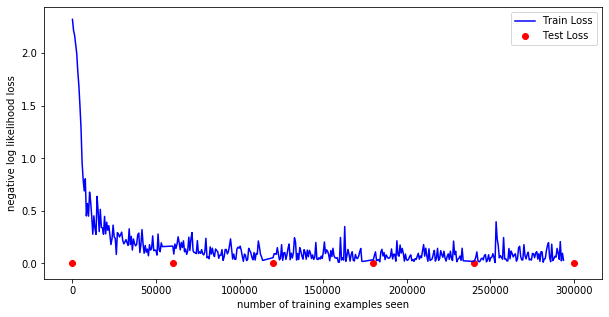

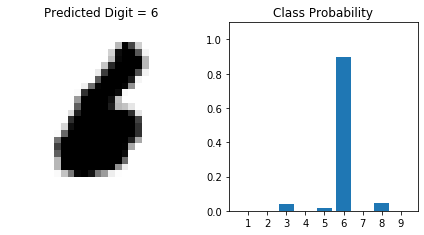

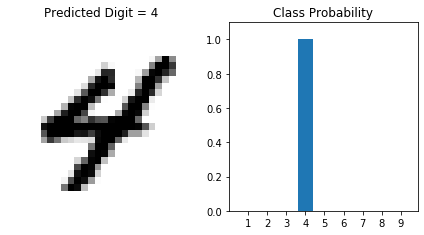

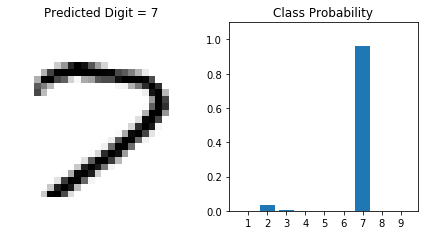

In [14]:
view_figure()
for i in range(3):
    view_prediction()